In [1]:
from google.colab import files
uploaded = files.upload()


Saving 15_fake_news_detection.csv to 15_fake_news_detection.csv


In [2]:
import pandas as pd

# Read CSV
df = pd.read_csv('15_fake_news_detection.csv')

# Show the head
df.head()


,title,text,label
0,Government Announces New Education Reforms,The education ministry has proposed reforms to...,real
1,Economy Shows Signs of Recovery,The new study conducted by international resea...,real
2,Aliens Land in Central Park,Sources claim that extraterrestrial beings wer...,fake
3,Aliens Land in Central Park,The celebrity stated that secret documents rev...,fake
4,New Study Reveals Health Benefits of Walking,The education ministry has proposed reforms to...,real


The dataset has 3 columns:

    title: Short title of the news

    text: Full news text (input for our model)

    label: real or fake (this is our target variable)

Let’s analyze the class distribution and check for missing values.



In [3]:
# Check dataset info
df.info()

# Check missing values
df.isnull().sum()

# Check class balance
df['label'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1000 non-null   object
 1   text    1000 non-null   object
 2   label   1000 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB


,count
label,
real,532
fake,468


**Text Cleaning and Preprocessing**

Before training a deep learning model, it’s essential to clean the raw text data to reduce noise and improve performance. In this step, we will:

    Convert all text to lowercase

    Remove URLs, mentions, hashtags, and punctuation

    Remove stopwords (e.g., “the”, “is”, “in”, etc.)

    Apply lemmatization to reduce words to their base forms

This will help us create a cleaner version of the news text, which improves the model's ability to learn meaningful patterns for fake news detection.

In [4]:
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK components
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning function
def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # links
    text = re.sub(r'\@w+|\#','', text)  # @user, hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # remove punctuation and numbers
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Apply to text column
df['clean_text'] = df['text'].apply(clean_text)

# Show result
df[['text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,text,clean_text
0,The education ministry has proposed reforms to...,education ministry proposed reform modernize c...
1,The new study conducted by international resea...,new study conducted international researcher s...
2,Sources claim that extraterrestrial beings wer...,source claim extraterrestrial being seen stepp...
3,The celebrity stated that secret documents rev...,celebrity stated secret document reveal shocki...
4,The education ministry has proposed reforms to...,education ministry proposed reform modernize c...


** Tokenization and Sequence Padding**

To feed the cleaned text into a deep learning model, we need to convert it into numerical format.

    We use Keras Tokenizer to convert words into integer sequences.

    We limit the vocabulary size to the top 5000 most frequent words.

    We apply padding to ensure all sequences have the same length (maxlen=200).

    Padding is done post-sequence, meaning zeros are added to the end of short texts.

This prepares the input data in a uniform format, making it suitable for model training using LSTM or other neural networks.

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences to the same length
padded_sequences = pad_sequences(sequences, maxlen=200, padding='post', truncating='post')

# Check shape
print("Shape of padded sequences:", padded_sequences.shape)


Shape of padded sequences: (1000, 200)


**Building the LSTM Model**

We will now build a simple neural network model using an LSTM (Long Short-Term Memory) layer. LSTMs are well-suited for text classification tasks because they can learn from word sequences and understand context over time.

Our model architecture will include:

    Embedding layer to learn word representations

    LSTM layer to capture sequence dependencies

    Dense layer with sigmoid activation to output binary classification (real or fake)

This model will be compiled with the binary cross-entropy loss and optimized using the Adam optimizer.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Parameters
vocab_size = 5000
embedding_dim = 64
max_length = 200

# Build the model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Show model summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

**Train-Test Split and Label Encoding**

Before training our model, we need to:

    Convert the target labels (real/fake) to binary format (1 and 0)

    Split the dataset into training and testing sets

We will use LabelEncoder to encode the labels and train_test_split from scikit-learn to create an 80/20 split.

In [7]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['label'])  # real = 1, fake = 0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Convert to numpy arrays (just to be safe)
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Check shape
print("Training shape:", X_train.shape, y_train.shape)
print("Testing shape:", X_test.shape, y_test.shape)


Training shape: (800, 200) (800,)
Testing shape: (200, 200) (200,)


** Training the Model**

Now we will train the LSTM model using the training data.

We will:

    Use batch_size = 32 and epochs = 5 (you can increase later)

    Monitor performance on validation data (X_test)

    Use verbose=2 for clean output

In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=2
)


Epoch 1/5
25/25 - 6s - 223ms/step - accuracy: 0.5238 - loss: 0.6932 - val_accuracy: 0.5650 - val_loss: 0.6877
Epoch 2/5
25/25 - 5s - 188ms/step - accuracy: 0.5250 - loss: 0.6937 - val_accuracy: 0.5650 - val_loss: 0.6888
Epoch 3/5
25/25 - 4s - 145ms/step - accuracy: 0.5088 - loss: 0.6939 - val_accuracy: 0.5650 - val_loss: 0.6890
Epoch 4/5
25/25 - 2s - 96ms/step - accuracy: 0.5188 - loss: 0.6942 - val_accuracy: 0.5650 - val_loss: 0.6864
Epoch 5/5
25/25 - 2s - 97ms/step - accuracy: 0.5238 - loss: 0.6927 - val_accuracy: 0.5650 - val_loss: 0.6896


Model Evaluation and Visualization

To better understand the model's training performance, we will plot:

    Training vs. Validation Accuracy

    Training vs. Validation Loss

These graphs help us detect overfitting, underfitting, and training stability.

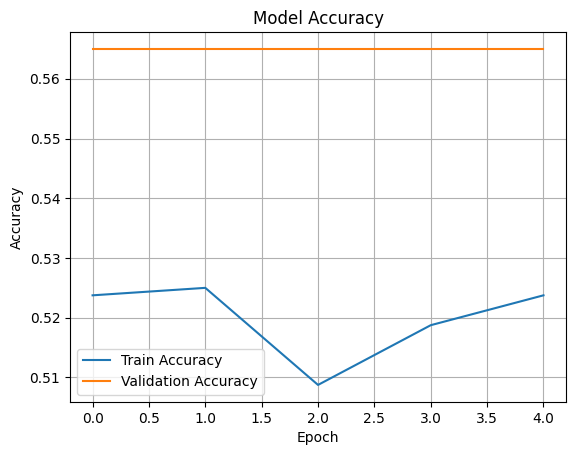

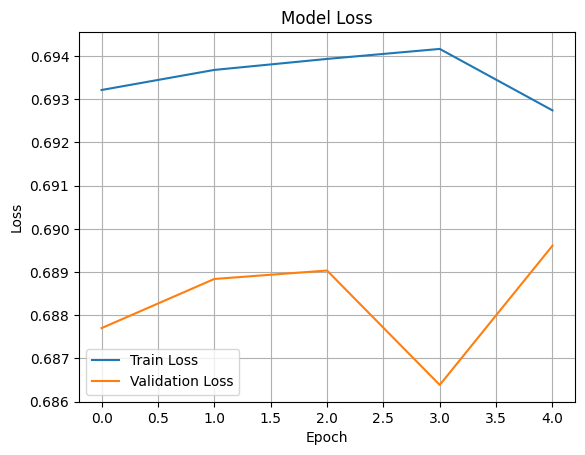

In [9]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


**Final Evaluation Metrics**

To understand the model’s real-world performance, we compute:

    Accuracy: Overall correctness

    Precision: Correctness of positive (fake) predictions

    Recall: Coverage of actual fake news

    F1 Score: Harmonic mean of precision and recall

    Confusion Matrix: Breakdown of true/false positives/negatives

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step
Accuracy: 0.565
Precision: 0.565
Recall: 1.0
F1 Score: 0.7220447284345048

Classification Report:
               precision    recall  f1-score   support

        Fake       0.00      0.00      0.00        87
        Real       0.56      1.00      0.72       113

    accuracy                           0.56       200
   macro avg       0.28      0.50      0.36       200
weighted avg       0.32      0.56      0.41       200



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


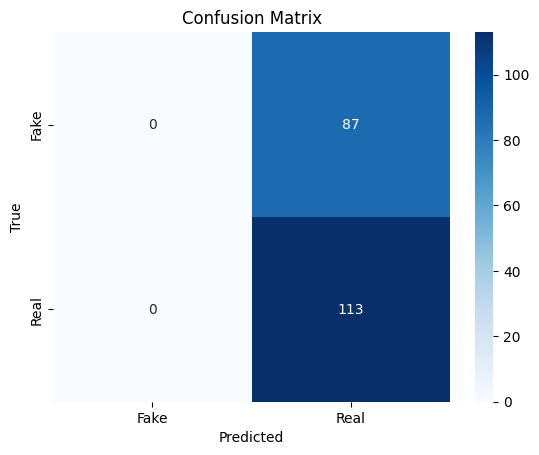

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred_classes))
print("Precision:", precision_score(y_test, y_pred_classes))
print("Recall:", recall_score(y_test, y_pred_classes))
print("F1 Score:", f1_score(y_test, y_pred_classes))

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred_classes, target_names=['Fake', 'Real']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
